In [1]:
from transformers import get_linear_schedule_with_warmup
from transformers import DistilBertForSequenceClassification,DistilBertTokenizerFast
from train_eval import train
from data_pipeline import data_pipeline
import evaluate
import torch
from torch import nn
from torch.optim import AdamW, Adam
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm, trange
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# hyperparameters
MAX_LEN = 150
BATCH_SIZE = 16
EPOCHS = 5
LR = 1e-5

In [3]:
data = pd.read_csv('data.csv')

In [44]:
data_view = data.sample(frac = 1)
data_view.head(10)

,content,sentiment
4359,Fine,1
2494,Super cool that you've added a garbage AI feat...,0
949,Quit nice though tiktok lite is faster in load...,2
8045,It's good but I'd appreciate it if they remove...,2
6980,Niraj💔😇 bihari,2
5996,"""Open in External Browser"" has been broken for...",0
2752,"More updates come, more bugs come. It's sicken...",0
9519,Unman m baba,2
8777,This app is really good! But filters is not ab...,0
11163,The app's performance is degrading. It crashes...,0


In [4]:
PRE_TRAINED_MODEL_NAME = 'distilbert/distilbert-base-uncased'
tokenizer = DistilBertTokenizerFast.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [5]:
train_dataloader, val_dataloader, test_dataloader = data_pipeline(tokenizer,data,BATCH_SIZE,MAX_LEN)

In [6]:
class_names = ['negative', 'neutral', 'positive']

In [7]:
model = DistilBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME, num_labels=3).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
optimizer = AdamW(model.parameters(), lr=LR)

total_steps = len(train_dataloader)*EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

### Training Loop

In [16]:
model_results = train(model=model, 
                        train_dataloader=train_dataloader,
                        val_dataloader=val_dataloader,
                        optimizer=optimizer,
                        scheduler=scheduler,
                        epochs=EPOCHS)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

train_steps:   0%|          | 0/675 [00:00<?, ?it/s]

val_steps:   0%|          | 0/75 [00:00<?, ?it/s]

Train loss: 0.9279 | Train accuracy: 54%
Val   loss: 0.832 | Val   accuracy: 63%


train_steps:   0%|          | 0/675 [00:00<?, ?it/s]

val_steps:   0%|          | 0/75 [00:00<?, ?it/s]

Train loss: 0.8069 | Train accuracy: 62%
Val   loss: 0.8208 | Val   accuracy: 62%


train_steps:   0%|          | 0/675 [00:00<?, ?it/s]

val_steps:   0%|          | 0/75 [00:00<?, ?it/s]

Train loss: 0.7249 | Train accuracy: 68%
Val   loss: 0.837 | Val   accuracy: 62%


train_steps:   0%|          | 0/675 [00:00<?, ?it/s]

val_steps:   0%|          | 0/75 [00:00<?, ?it/s]

Train loss: 0.6514 | Train accuracy: 72%
Val   loss: 0.8664 | Val   accuracy: 61%


train_steps:   0%|          | 0/675 [00:00<?, ?it/s]

val_steps:   0%|          | 0/75 [00:00<?, ?it/s]

Train loss: 0.598 | Train accuracy: 76%
Val   loss: 0.8758 | Val   accuracy: 62%


In [32]:
model_results['train_loss'] = torch.tensor(model_results['train_loss'], device='cpu')
model_results['val_loss'] = torch.tensor(model_results['val_loss'], device='cpu')

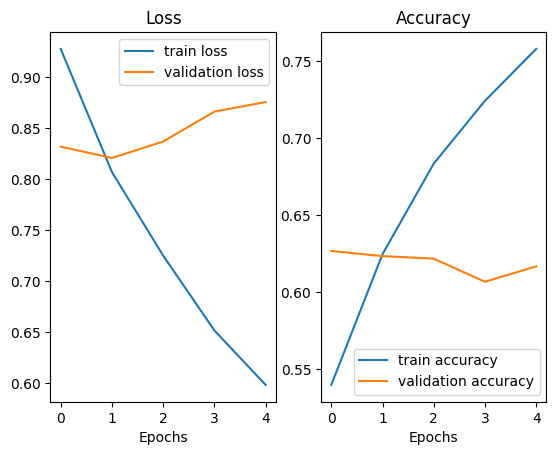

In [33]:
# Plot loss
plt.subplot(1, 2, 1)
plt.plot(model_results['train_loss'].clone().detach(), label='train loss')
plt.plot(model_results['val_loss'].clone().detach(), label='validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(model_results['train_acc'], label='train accuracy')
plt.plot(model_results['val_acc'], label='validation accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend();

In [11]:
test_metric = evaluate.load("accuracy")
model.eval()
for i,batch in enumerate(test_dataloader):
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.inference_mode():
        outputs = model(**batch)
    
    #print(batch)
    print(tokenizer.decode(batch['input_ids'][0], skip_special_tokens=True))
    print()
    logits = outputs.logits
    predictions = torch.softmax(logits,dim=1)
    predictions = torch.argmax(predictions, dim=-1)
    test_metric.add_batch(predictions=predictions, references=batch["labels"])
    print(f"Label : {class_names[predictions.max()]}")
    print("--"*15)
    if i == 7:
        break

add a post or add a story is not working in my phone. it always ends up as app stop responding. it's frustrating.

Label : negative
------------------------------
i don't like how the feed automatically scrolls to the next post when i'm trying to read a caption. the only way around it is to go to the posters profile, search for that video, and read it from there. pita. also don't care for all the suggested content. i never see any content from the accounts i actually follow. it's just continuous suggested content and ads, one after the other. maybe 10 posts down & finally i come across one from someone i follow. annoying.

Label : negative
------------------------------
late message problem

Label : negative
------------------------------
3stars sorry

Label : neutral
------------------------------
i used to like and use the lite app until they started suggesting marketplace items to me on the menu page. i don't want to see items after i leave the marketplace which is why i turned off 

In [37]:
def get_predictions(model, data_loader):
    
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    model.eval()
    for i,batch in enumerate(test_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.inference_mode():
                outputs = model(**batch)
                texts = tokenizer.decode(batch['input_ids'][0], skip_special_tokens=True)
                targets = batch["labels"].to(device)
                logits = outputs.logits
                preds = torch.softmax(logits,dim=1)
                preds = torch.argmax(preds, dim=-1)
                review_texts.append(texts)
                predictions.append(preds.cpu().item())
                real_values.append(targets.cpu().item())
    
    return review_texts, predictions, real_values

In [38]:
y_review_texts, y_pred, y_test = get_predictions(
  model,
  test_dataloader
)

In [39]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.58      0.56      0.57       190
     neutral       0.46      0.41      0.43       199
    positive       0.62      0.71      0.66       211

    accuracy                           0.56       600
   macro avg       0.55      0.56      0.55       600
weighted avg       0.56      0.56      0.56       600



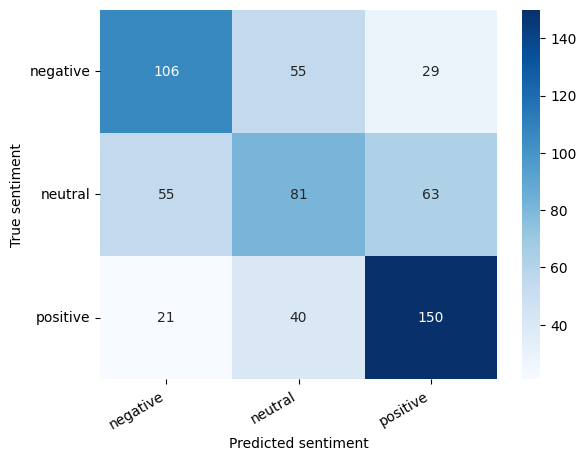

In [40]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

### Predict on raw text

In [60]:
def predict(model, text, tokenizer, device):
    encoded_text = tokenizer(text, truncation=True, padding="max_length",
                             max_length=MAX_LEN, return_tensors='pt')

    input_ids = encoded_text['input_ids'].to(device)
    attention_mask = encoded_text['attention_mask'].to(device)

    outputs = model(input_ids, attention_mask)
    logits = outputs.logits
    preds_prob = torch.softmax(logits,dim=1)
    preds = torch.argmax(preds_prob, dim=-1)

    print(f'Review text: {raw_text}')
    print(f'Sentiment  : {class_names[preds]}')
    print(f'Score  : {preds_prob.max():.4f}')

In [66]:
raw_text = 'Wow! I love this app'
predict(model, raw_text, tokenizer, device)

Review text: Wow! I love this app
Sentiment  : positive
Score  : 0.8840


### Saving Model

In [67]:
saved_model = torch.save(model.state_dict(), 'model_0.bin')
saved_model